In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def GaussianKernel(x, x_train, h):
    return (1 / (h * np.sqrt(2 * np.pi))) * np.exp(-((x - x_train) ** 2) / (2 * h ** 2))

In [3]:
def EpanechnikovKernel(x, x_train, h):
    distances = (x - x_train) / h
    kernel_values = np.zeros_like(distances)
    for i, d in enumerate(distances):
        if np.abs(d) <= 1:
            kernel_values[i] = (3 / 4) * (1 - d**2)
        else:
            kernel_values[i] = 0.0
    return kernel_values

In [4]:
def NadarayaWatsonKernel(x, x_train, y_train, h, kernel_func):
    kernel = kernel_func(x, x_train, h)
    if np.sum(kernel) == 0:
        return np.mean(y_train)
    else:
        return np.sum(kernel * y_train) / np.sum(kernel)

In [5]:
df = pd.read_csv('glass.dat', sep=r'\s+', engine='python', usecols=['RI', 'Al'])
X = df['Al'].to_numpy()
Y = df['RI'].to_numpy()
sorted_indices = np.argsort(X)
X_sorted = X[sorted_indices]

In [6]:
def kfold_split(X, k, shuffle=True, random_state=None):
    if shuffle:
        if random_state is not None:
            np.random.seed(random_state)
        indices = np.random.permutation(len(X))
    else:
        indices = np.arange(len(X))
        
    fold_size = len(X) // k
    folds = []
    
    for i in range(k):
        start = i * fold_size
        end = start + fold_size if i != k - 1 else len(X)
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        folds.append((train_indices, test_indices))
    
    return folds

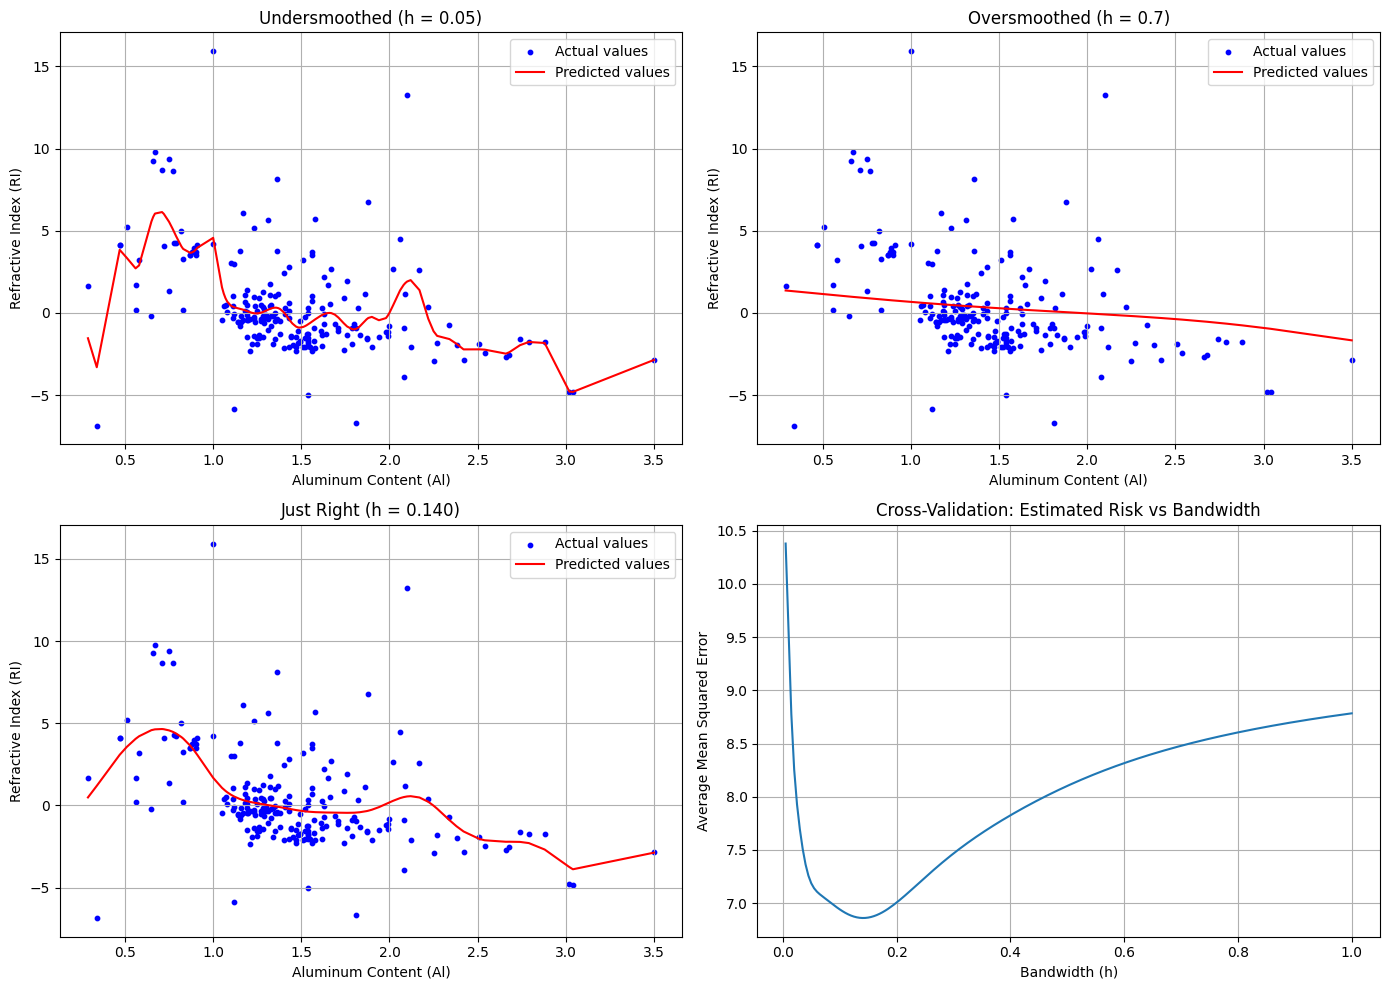

In [7]:
k = 5
folds = kfold_split(X, k, shuffle=True, random_state=42)

bandwidths = np.arange(0.005, 1.005, 0.005)
average_mse_values = []

for h in bandwidths:
    mse_values = []
    for train_index, test_index in folds:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        Y_pred = np.array([NadarayaWatsonKernel(x_test, X_train, Y_train, h, GaussianKernel) for x_test in X_test])
        
        mse = np.mean((Y_pred - Y_test) ** 2)
        mse_values.append(mse)
    
    average_mse_values.append(np.mean(mse_values))

min_mse = np.nanmin(average_mse_values)
optimal_bandwidth = bandwidths[average_mse_values.index(min_mse)]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

h = 0.05
Y_pred_sorted = np.array([NadarayaWatsonKernel(x, X, Y, h, GaussianKernel) for x in X_sorted])
axs[0, 0].scatter(X, Y, color='blue', label='Actual values', s=10)
axs[0, 0].plot(X_sorted, Y_pred_sorted, color='red', label='Predicted values')
axs[0, 0].set_title('Undersmoothed (h = 0.05)')
axs[0, 0].set_xlabel('Aluminum Content (Al)')
axs[0, 0].set_ylabel('Refractive Index (RI)')
axs[0, 0].legend()
axs[0, 0].grid(True)

h = 0.7
Y_pred_sorted = np.array([NadarayaWatsonKernel(x, X, Y, h, GaussianKernel) for x in X_sorted])
axs[0, 1].scatter(X, Y, color='blue', label='Actual values', s=10)
axs[0, 1].plot(X_sorted, Y_pred_sorted, color='red', label='Predicted values')
axs[0, 1].set_title('Oversmoothed (h = 0.7)')
axs[0, 1].set_xlabel('Aluminum Content (Al)')
axs[0, 1].set_ylabel('Refractive Index (RI)')
axs[0, 1].legend()
axs[0, 1].grid(True)

h = optimal_bandwidth
Y_pred_sorted = np.array([NadarayaWatsonKernel(x, X, Y, h, GaussianKernel) for x in X_sorted])
axs[1, 0].scatter(X, Y, color='blue', label='Actual values', s=10)
axs[1, 0].plot(X_sorted, Y_pred_sorted, color='red', label='Predicted values')
axs[1, 0].set_title(f'Just Right (h = {optimal_bandwidth:.3f})')
axs[1, 0].set_xlabel('Aluminum Content (Al)')
axs[1, 0].set_ylabel('Refractive Index (RI)')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(bandwidths, average_mse_values, linestyle='-')
axs[1, 1].set_title('Cross-Validation: Estimated Risk vs Bandwidth')
axs[1, 1].set_xlabel('Bandwidth (h)')
axs[1, 1].set_ylabel('Average Mean Squared Error')
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../images/4/gaussian_kernel_regression.png', dpi=300)
plt.show()

In [8]:
variance = np.mean((Y_pred_sorted - np.mean(Y_pred_sorted)) ** 2)
print(f"Variance: {variance}")
print(f"Minimum Risk: {min_mse}")

Variance: 2.342943124789813
Minimum Risk: 6.860559991305064


##### Optimal bandwidth corresponding to the Gaussian Kernel is h = 0.140

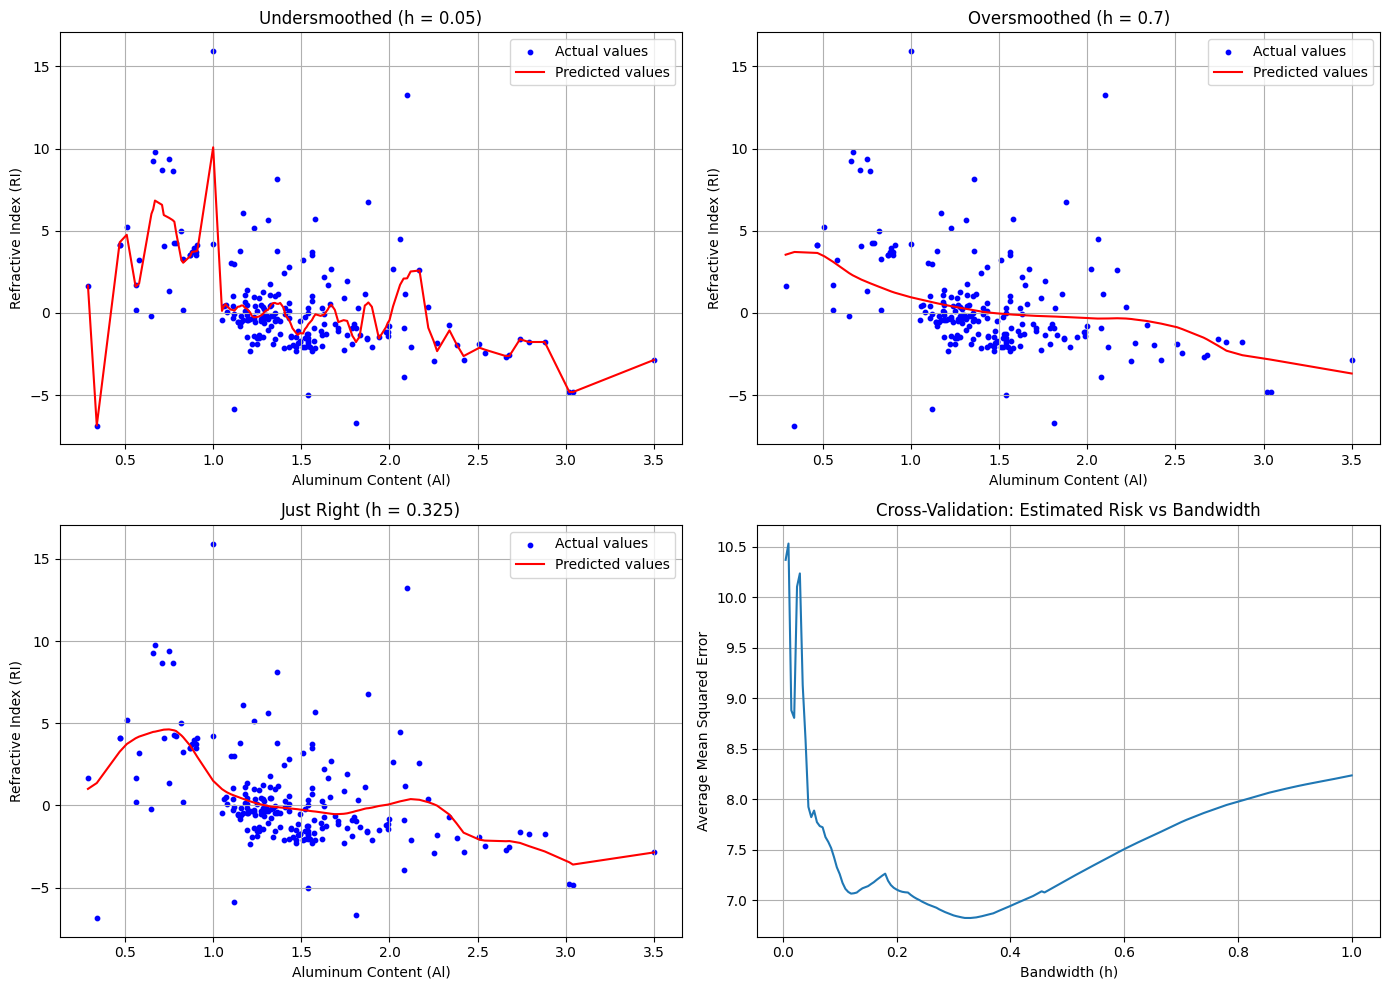

In [9]:
k = 5
folds = kfold_split(X, k, shuffle=True, random_state=42)

bandwidths = np.arange(0.005, 1.005, 0.005)
average_mse_values = []

for h in bandwidths:
    mse_values = []
    for train_index, test_index in folds:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        Y_pred = np.array([NadarayaWatsonKernel(x_test, X_train, Y_train, h, EpanechnikovKernel) for x_test in X_test])
        
        mse = np.mean((Y_pred - Y_test) ** 2)
        mse_values.append(mse)
    
    average_mse_values.append(np.mean(mse_values))

min_mse = np.nanmin(average_mse_values)
optimal_bandwidth = bandwidths[average_mse_values.index(min_mse)]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

h = 0.05
Y_pred_sorted = np.array([NadarayaWatsonKernel(x, X, Y, h, EpanechnikovKernel) for x in X_sorted])
axs[0, 0].scatter(X, Y, color='blue', label='Actual values', s=10)
axs[0, 0].plot(X_sorted, Y_pred_sorted, color='red', label='Predicted values')
axs[0, 0].set_title('Undersmoothed (h = 0.05)')
axs[0, 0].set_xlabel('Aluminum Content (Al)')
axs[0, 0].set_ylabel('Refractive Index (RI)')
axs[0, 0].legend()
axs[0, 0].grid(True)

h = 0.7
Y_pred_sorted = np.array([NadarayaWatsonKernel(x, X, Y, h, EpanechnikovKernel) for x in X_sorted])
axs[0, 1].scatter(X, Y, color='blue', label='Actual values', s=10)
axs[0, 1].plot(X_sorted, Y_pred_sorted, color='red', label='Predicted values')
axs[0, 1].set_title('Oversmoothed (h = 0.7)')
axs[0, 1].set_xlabel('Aluminum Content (Al)')
axs[0, 1].set_ylabel('Refractive Index (RI)')
axs[0, 1].legend()
axs[0, 1].grid(True)

h = optimal_bandwidth
Y_pred_sorted = np.array([NadarayaWatsonKernel(x, X, Y, h, EpanechnikovKernel) for x in X_sorted])
axs[1, 0].scatter(X, Y, color='blue', label='Actual values', s=10)
axs[1, 0].plot(X_sorted, Y_pred_sorted, color='red', label='Predicted values')
axs[1, 0].set_title(f'Just Right (h = {optimal_bandwidth:.3f})')
axs[1, 0].set_xlabel('Aluminum Content (Al)')
axs[1, 0].set_ylabel('Refractive Index (RI)')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(bandwidths, average_mse_values, linestyle='-')
axs[1, 1].set_title('Cross-Validation: Estimated Risk vs Bandwidth')
axs[1, 1].set_xlabel('Bandwidth (h)')
axs[1, 1].set_ylabel('Average Mean Squared Error')
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../images/4/epanechnikov_kernel_regression.png', dpi=300)
plt.show()

In [10]:
variance = np.mean((Y_pred_sorted - np.mean(Y_pred_sorted)) ** 2)
print(f"Variance: {variance}")
print(f"Minimum Risk: {min_mse}")

Variance: 2.3282008055140757
Minimum Risk: 6.825535230942791


##### Optimal bandwidth corresponding to the Epanechnikov Kernel is h = 0.325